## 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet

# Настройка pandas для отображения всех столбцов
pd.set_option('display.max_columns', None)

## 2. Определение вспомогательных функций

Этот блок содержит все функции, которые буду использовать в дальнейшем

In [2]:
def create_date_column(df: pd.DataFrame, year_col: str = 'year', week_col: str = 'week_number') -> pd.DataFrame:
    """
    Создает столбец 'date' из столбцов года и номера недели.

    Args:
        df: Исходный DataFrame.
        year_col: Название столбца с годом.
        week_col: Название столбца с номером недели.

    Returns:
        DataFrame с добавленным столбцом 'date'.
    """
    def get_date(row):
        year = int(row[year_col])
        week = int(row[week_col])
        return pd.to_datetime(f"{year}-W{week}-1", format="%Y-W%W-%w")

    df['date'] = df.apply(get_date, axis=1)
    return df


def aggregate_weekly_data(df: pd.DataFrame, group_cols: list, value_col: str, agg_func: str = 'sum') -> pd.DataFrame:
    """
    Агрегирует данные по указанным столбцам (обычно по неделям и ресторанам).

    Args:
        df: Исходный DataFrame.
        group_cols: Список столбцов для группировки.
        value_col: Столбец, значения которого нужно агрегировать.
        agg_func: Функция агрегации ('sum', 'mean', 'count' и т.д.).

    Returns:
        Агрегированный DataFrame.
    """
    weekly_data = df.groupby(group_cols)[value_col].agg(agg_func).reset_index()
    return weekly_data


def interpolate_and_smooth(series: pd.Series, method: str = 'linear', order: int = 3, smoothing_window: int = 3) -> pd.Series:
    """
    Заполняет пропуски нулями, выполняет интерполяцию и сглаживание.
    Интерполяция происходит *только* между ненулевыми значениями.

    Args:
        series: Временной ряд для обработки.
        method: Метод интерполяции ('linear', 'spline', 'polynomial' и т.д.).
        order: Порядок полинома (для 'spline' и 'polynomial').
        smoothing_window: Размер окна для сглаживания (в неделях).

    Returns:
        Обработанный временной ряд.
    """
    series_filled = series.fillna(0)
    non_zero_indices = series_filled[series_filled != 0].index

    if len(non_zero_indices) == 0:
        return series_filled

    first_non_zero = non_zero_indices.min()
    last_non_zero = non_zero_indices.max()

    # Заменяем нули на NaN только внутри ненулевых границ
    series_filled.loc[first_non_zero:last_non_zero] = series_filled.loc[first_non_zero:last_non_zero].replace(0, np.nan)

    # Интерполируем NaN значения
    series_interpolated = series_filled.interpolate(method=method, order=order, limit_direction='both')

    # Сглаживаем результат скользящим средним
    series_smoothed = series_interpolated.rolling(window=smoothing_window, center=True, min_periods=1).mean()

    return series_smoothed


def detect_outliers_prophet(df: pd.DataFrame, value_col: str = 'checks_qty_interp', interval_width: float = 0.999, original_index: pd.Index = None) -> pd.Series:
    """
    Обнаруживает выбросы во временном ряду с помощью Prophet.

    Args:
        df: DataFrame с данными для *одного* ресторана.  Должен содержать 'date' и value_col.
        value_col: Название столбца со значениями временного ряда.
        interval_width: Ширина доверительного интервала Prophet (0-1).
                        Большие значения = менее строгий детектор выбросов.
        original_index: Исходный индекс группы (для корректного возврата Series).

    Returns:
        Булева маска выбросов (True - выброс).
    """
    df_prophet = df[['date', value_col]].rename(columns={'date': 'ds', value_col: 'y'})
    model = Prophet(interval_width=interval_width, seasonality_mode='additive')
    model.fit(df_prophet)
    forecast = model.predict(df_prophet)
    df_merged = df_prophet.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
    df_merged['is_outlier'] = (df_merged['y'] < df_merged['yhat_lower']) | (df_merged['y'] > df_merged['yhat_upper'])
    return pd.Series(df_merged['is_outlier'].values, index=original_index)


def plot_restaurant_data(restaurant_data: pd.DataFrame, value_col: str, outliers_col: str, title_prefix: str = "Restaurant"):
    """
    Строит график для одного ресторана: исходные данные, сглаженные данные и выбросы.

    Args:
        restaurant_data:  Данные для одного ресторана.
        value_col:  Название столбца с исходными данными.
        outliers_col: Название столбца с булевой маской выбросов.
        title_prefix: Префикс для заголовка графика.
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    color_original = 'skyblue'
    color_filtered = 'mediumseagreen'
    color_outliers = 'crimson'

    sns.lineplot(x='date', y=value_col, data=restaurant_data, label=f'Исходные данные ({value_col})', color=color_original, linewidth=1.5, ax=ax)
    sns.lineplot(x='date', y='checks_qty_interp_filtered', data=restaurant_data, label='Данные (сглаженные, выбросы удалены)', color=color_filtered, linewidth=2, ax=ax)
    sns.scatterplot(x=restaurant_data[restaurant_data[outliers_col]]['date'],
                    y=restaurant_data[restaurant_data[outliers_col]][value_col],
                    color=color_outliers, label=f'Выбросы ({len(restaurant_data[restaurant_data[outliers_col]])})',
                    marker='x', s=80, linewidths=2, ax=ax)

    ax.set_xlabel('Дата', fontsize=12)
    ax.set_ylabel('Количество чеков', fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle=':', linewidth=0.5)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1.05), borderaxespad=0., fontsize=10)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()

    if not restaurant_data['date'].isnull().any():
        for year in restaurant_data['year'].unique():
            year_start = pd.to_datetime(f'{year}-01-01')
            if restaurant_data['date'].min() <= year_start <= restaurant_data['date'].max():
                ax.axvline(x=year_start, color='gray', linestyle=':', alpha=0.5)

    sns.despine(top=True, right=True)
    plt.title(f'{title_prefix} {restaurant_data["rest_ncode"].iloc[0]}: Анализ количества чеков', fontsize=14)
    plt.tight_layout()
    plt.show()


def calculate_seasonality_coefficients(weekly_checks_full: pd.DataFrame, value_col: str, smoothing_window: int = 3) -> pd.DataFrame:
    """
    Вычисляет коэффициенты сезонности для каждого ресторана и каждой недели.

    Args:
        weekly_checks_full:  Полный DataFrame с данными по всем ресторанам.
        value_col: Столбец с данными для анализа.
        smoothing_window: Размер окна для сглаживания коэффициентов (в неделях).

    Returns:
        DataFrame с рассчитанными коэффициентами сезонности.
    """
    weekly_avg = weekly_checks_full.groupby(['rest_ncode', 'week_number'])[value_col].mean().reset_index()
    restaurant_avg = weekly_avg.groupby('rest_ncode')[value_col].mean().reset_index()
    restaurant_avg.rename(columns={value_col: 'restaurant_avg'}, inplace=True)
    weekly_avg = weekly_avg.merge(restaurant_avg, on='rest_ncode')
    weekly_avg['seasonality_coeff'] = weekly_avg[value_col] / weekly_avg['restaurant_avg']
    weekly_avg['seasonality_coeff_smoothed'] = weekly_avg.groupby('rest_ncode')['seasonality_coeff'].transform(
        lambda x: x.rolling(window=smoothing_window, center=True, min_periods=1).mean()
    )
    return weekly_avg


def create_result_tables(weekly_avg: pd.DataFrame) -> tuple[pd.DataFrame, int, pd.DataFrame]:
    """
    Создает три результирующие таблицы:
        1. Ресторан - Кол-во недель с заполненным коэфф-том.
        2. Кол-во ресторано-недель с коэфф-том > 2 или < 0.4.
        3. Ресторан - Неделя - Коэфф-т сезонности.

    Args:
      weekly_avg: DataFrame, содержащий сглаженные коэффициенты сезонности.

    Returns:
      Кортеж из трех DataFrame (table1, table2_count, table3).
    """
    table1 = weekly_avg.groupby('rest_ncode')['week_number'].count().reset_index()
    table1.columns = ['Ресторан', 'Кол-во недель c заполненным кофф-том']
    table2_count = weekly_avg[(weekly_avg['seasonality_coeff_smoothed'] > 2) | (weekly_avg['seasonality_coeff_smoothed'] < 0.4)].shape[0]
    table3 = weekly_avg[['rest_ncode', 'week_number', 'seasonality_coeff_smoothed']]
    table3.columns = ['Ресторан', 'Неделя', 'Коэфф-т сезонности']
    return table1, table2_count, table3

## 3. Загрузка и предобработка данных

In [3]:
df = pd.read_csv("rest_checks.csv", sep=";", parse_dates=["check_dt"], date_format='mixed')

df['week_number'] = df['check_dt'].dt.isocalendar().week
df['year'] = df['check_dt'].dt.isocalendar().year

print(f"Минимальная дата: {df['check_dt'].min()}")
print(f"Максимальная дата: {df['check_dt'].max()}")
print("\nПервые 5 строк данных:")
display(df.head())
print("\nИнформация о пропусках:")
display(df.isnull().sum())

Минимальная дата: 2023-01-01 00:00:00
Максимальная дата: 2024-12-29 00:00:00

Первые 5 строк данных:


,rest_ncode,check_dt,checks_qty,regionrf_name,restformat_name,week_number,year
0,1031,2024-10-13,298,Волгоградская область,IL,41,2024
1,70,2023-06-09,379,Город Москва,FC,23,2023
2,1025,2023-01-06,146,Нижегородская область,FC,1,2023
3,887,2024-01-30,169,Московская область,IL,5,2024
4,313,2024-01-25,132,Курская область,FC,4,2024



Информация о пропусках:


rest_ncode         0
check_dt           0
checks_qty         0
regionrf_name      0
restformat_name    0
week_number        0
year               0
dtype: int64

## 4. Агрегация данных и создание полного набора недель

1.  Агрегируем исходные данные по ресторанам и неделям (`weekly_checks`).
2.  Создаем все возможные комбинации "ресторан - год - неделя" (`all_weeks_df`).
3.  Дополняем `all_weeks_df` данными о продажах из `weekly_checks`, пропуски заполняем нулями.
4.  Добавляем столбец `date`.

In [4]:
# Агрегация данных по ресторанам и неделям
weekly_checks = aggregate_weekly_data(df, ['rest_ncode', 'year', 'week_number'], 'checks_qty')

# Создание полного набора комбинаций "ресторан - год - неделя"
all_restaurants = df['rest_ncode'].unique()
all_weeks = pd.MultiIndex.from_product(
    [all_restaurants, [2023, 2024], range(1, 52)],
    names=['rest_ncode', 'year', 'week_number']
)
all_weeks_df = pd.DataFrame(index=all_weeks).reset_index()

# Объединение полного набора с фактическими данными
weekly_checks_full = all_weeks_df.merge(weekly_checks, on=['rest_ncode', 'year', 'week_number'], how='left')

# Заполнение пропущенных значений нулями (первичная обработка)
weekly_checks_full['checks_qty'] = weekly_checks_full['checks_qty'].fillna(0)

# Создание столбца 'date' (после заполнения пропусков, чтобы избежать ошибок)
weekly_checks_full = create_date_column(weekly_checks_full)

## 5. Интерполяция пропусков

**Заполнение пропусков:** Линейная интерполяция.

Предполагаем плавное изменение количества чеков от недели к неделе.

**Альтернативы:**

*   **Нули:**  Искажают анализ сезонности (пропуски заполняются нулями только для агрегации, выполнено в разделе 4).
*   **Среднее:** Сглаживает динамику.
*   **Сплайны, полиномы:** Могут привести к переобучению.

In [5]:
weekly_checks_full['checks_qty_interp'] = weekly_checks_full.groupby('rest_ncode')['checks_qty'].transform(
    interpolate_and_smooth
)

### 6. Обнаружение и обработка выбросов с помощью Prophet

**Обнаружение выбросов:**  Модель Prophet

**Преимущества Prophet:**

*   Учитывает сезонность и тренд.
*   Строит доверительные интервалы.
*   Устойчив к пропускам.

**Параметр `interval_width=0.999`:**  Широкий интервал (99.9%) = низкая чувствительность, выявляются только экстремальные выбросы.
    Можно уменьшить для большей чувствительности (риск ложных срабатываний).

In [6]:
# Обнаружение выбросов для каждого ресторана с помощью Prophet
weekly_checks_full['is_outlier'] = weekly_checks_full.groupby('rest_ncode', group_keys=False).apply(
    lambda group: detect_outliers_prophet(group.reset_index(), value_col='checks_qty_interp', original_index=group.index), include_groups=False
)

# Создаем новый столбец 'checks_qty_interp_filtered', копируя в него данные из 'checks_qty_interp'
weekly_checks_full['checks_qty_interp_filtered'] = weekly_checks_full['checks_qty_interp']

# Заменяем значения, определенные как выбросы (is_outlier == True), на NaN в столбце 'checks_qty_interp_filtered'
weekly_checks_full.loc[weekly_checks_full['is_outlier'], 'checks_qty_interp_filtered'] = np.nan

# Выполняем линейную интерполяцию для заполнения NaN значений в столбце 'checks_qty_interp_filtered'
# Интерполяция выполняется для каждой группы (ресторана) отдельно
weekly_checks_full['checks_qty_interp_filtered'] = weekly_checks_full.groupby('rest_ncode')['checks_qty_interp_filtered'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')
)

02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1]

## 7. Построение графиков для визуализации обработки выбросов

Строим графики для нескольких ресторанов, чтобы визуально оценить результаты обработки выбросов. \
На графиках отображаются исходные данные, данные после интерполяции и сглаживания, а также сами выбросы.

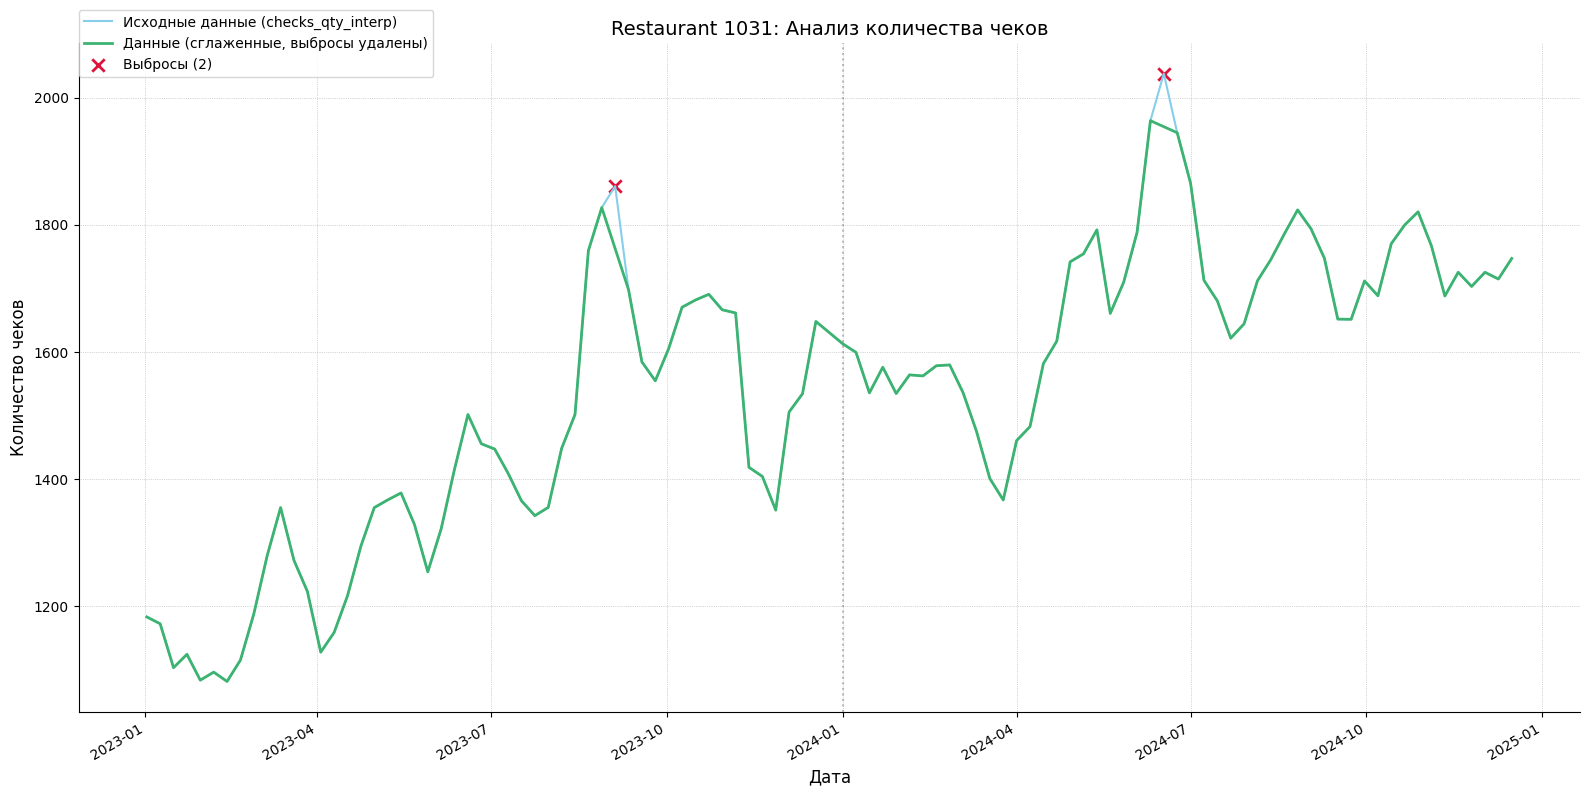

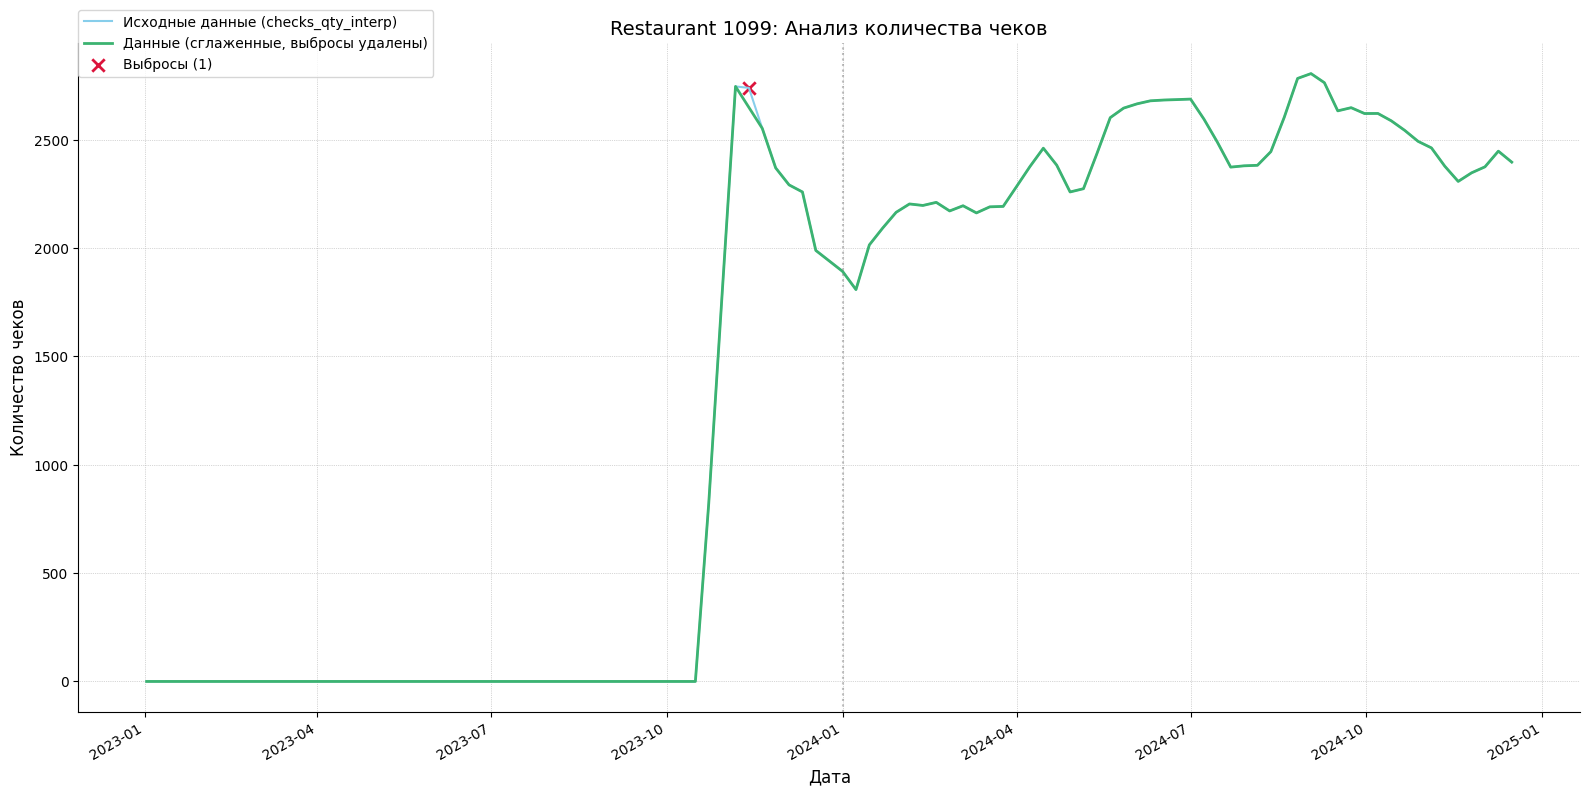

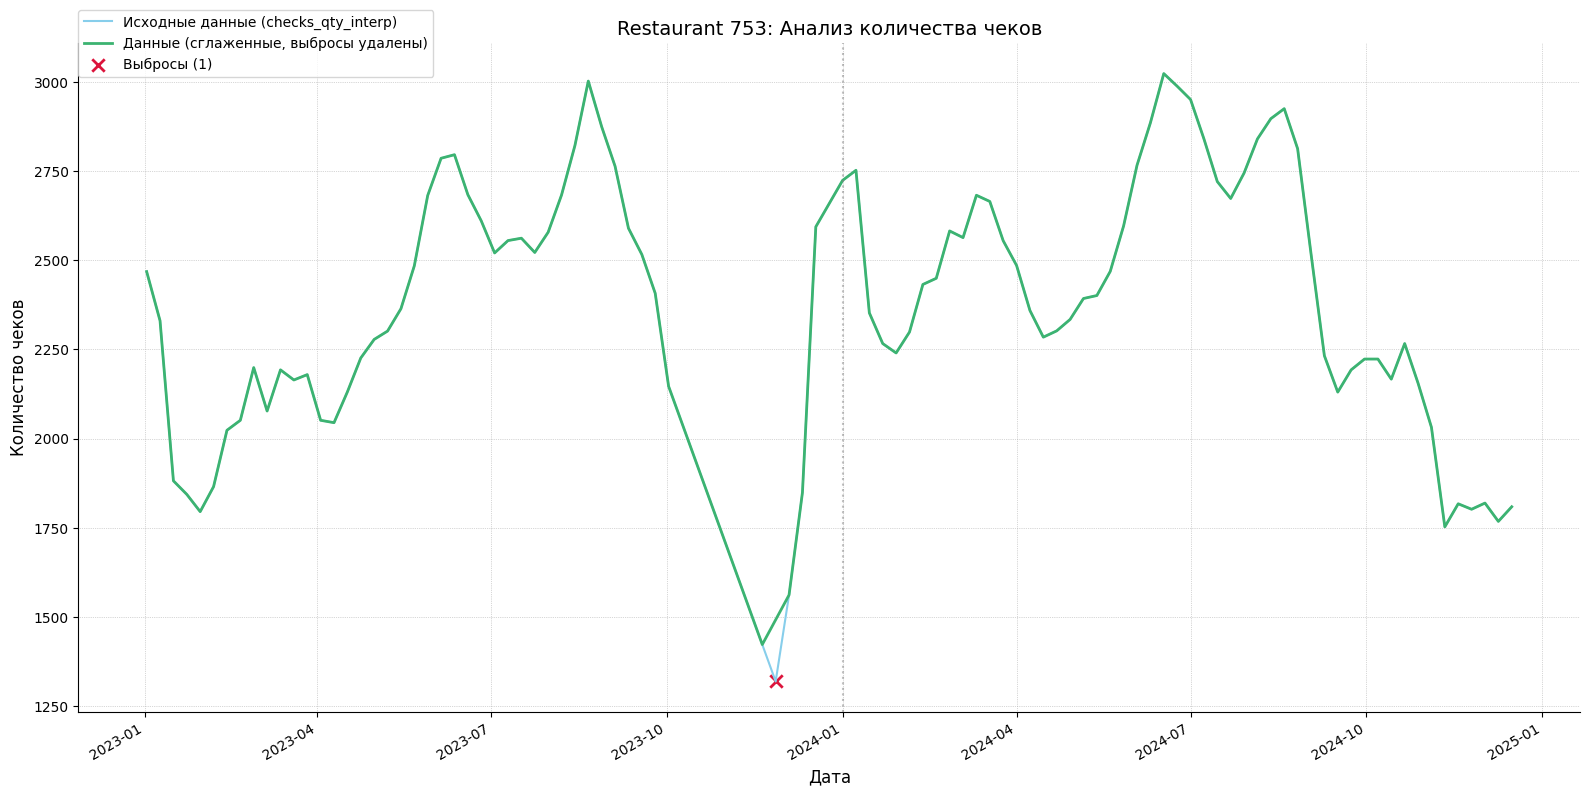

In [7]:
restaurants_with_outliers = weekly_checks_full[weekly_checks_full['is_outlier']]['rest_ncode'].unique()
num_restaurants_to_plot = 3
sample_restaurants = restaurants_with_outliers[:min(num_restaurants_to_plot, len(restaurants_with_outliers))]

for rest_ncode in sample_restaurants:
    restaurant_data = weekly_checks_full[weekly_checks_full['rest_ncode'] == rest_ncode]
    plot_restaurant_data(restaurant_data, 'checks_qty_interp', 'is_outlier')

In [8]:
len(restaurants_with_outliers)

239

## 8. Расчет коэффициентов сезонности

Вычисляем коэффициенты сезонности для каждого ресторана и каждой недели. \
Коэффициент сезонности рассчитывается как отношение среднего количества чеков за данную неделю в данном ресторане к среднему количеству чеков за все недели в данном ресторане.  Полученные коэффициенты сглаживаются с помощью скользящего среднего.

In [9]:
weekly_avg = calculate_seasonality_coefficients(weekly_checks_full, 'checks_qty_interp_filtered')
table1, table2_count, table3 = create_result_tables(weekly_avg)

## 9. Вывод результатов

In [10]:
# 9. Вывод результатов
print("Таблица 1: Ресторан - Кол-во недель с заполненным коэфф-том")
display(table1)

print("\nТаблица 2: Кол-во ресторано-недель с коэфф-том больше 2 или меньше 0.4")
print(table2_count)

print("\nТаблица 3: Ресторан - Неделя - Коэфф-т сезонности")
display(table3)

Таблица 1: Ресторан - Кол-во недель с заполненным коэфф-том


,Ресторан,Кол-во недель c заполненным кофф-том
0,1,51
1,2,51
2,3,51
3,4,51
4,5,51
...,...,...
864,9060,51
865,9061,51
866,9062,51
867,9063,51



Таблица 2: Кол-во ресторано-недель с коэфф-том больше 2 или меньше 0.4
1154

Таблица 3: Ресторан - Неделя - Коэфф-т сезонности


,Ресторан,Неделя,Коэфф-т сезонности
0,1,1,0.994355
1,1,2,0.966469
2,1,3,0.929325
3,1,4,0.901648
4,1,5,0.902749
...,...,...,...
44314,9064,47,0.872729
44315,9064,48,0.830747
44316,9064,49,0.818758
44317,9064,50,0.832542
